# Plot Posteriors

This notebook uses the public code to plot the posterior distributions from MultiSWAG and pyDelfi

In [1]:
import sys
import torch
import numpy as np
import getdist.plots
from getdist.mcsamples import loadMCSamples
sys.path.append("../cosmoswag") 
from swag import SWAGModel
from cmb_simulator import normalize_params, bin_cls

### Load the parameters

I am using the last simulation for validation

In [21]:
cls = np.load('../cosmoswag/data/cmb_sims/cls.npy')
params = np.load('../cosmoswag/data/cmb_sims/params.npy')

theta_norm = normalize_params(params)
_, binned_cls = bin_cls(cls, 250)

x = torch.tensor(binned_cls[-1:], dtype = torch.float32)

maxs = np.array([90, 0.05, 0.5, 3.5, 1])
mins = np.array([50, 0.01, 0.01, 1.5, 0.8])

### Load the pyDelfi chain

In [22]:
pydelfi = loadMCSamples('../cosmoswag/data/chains/pydelfi')

### Load the multiSWAG model and generate samples

In [30]:
nin = binned_cls.shape[1]
npars = params.shape[1]

model = SWAGModel(nin=nin, npars = npars)
state_dict, _, _, _ = torch.load('../cosmoswag/data/saved_models/swag')
model.load_state_dict(state_dict)
mean, invcov = model.predict(x)
mean = mean[0].detach().numpy()
cov = torch.inverse(invcov[0]).detach().numpy()

In [32]:
mean = mean*(maxs-mins)+mins
cmaxs = np.outer(maxs, maxs)
cmins = np.outer(mins, mins)
cov = cov*(cmaxs-cmins)
X = np.random.multivariate_normal(mean, cov, 10000)

/Users/Pablo/.local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: covariance is not positive-semidefinite.
  """


In [34]:
names = ["H0", "omch2",  "ombh2", "As", "ns"]
labels =  ["H_0", "\Omega_\mathrm{c} h^2", "\Omega_\mathrm{b} h^2", "\log A", "n_s"]
swag = getdist.MCSamples(samples=X,names = names, labels = labels)

Removed no burn in


### Generate plots

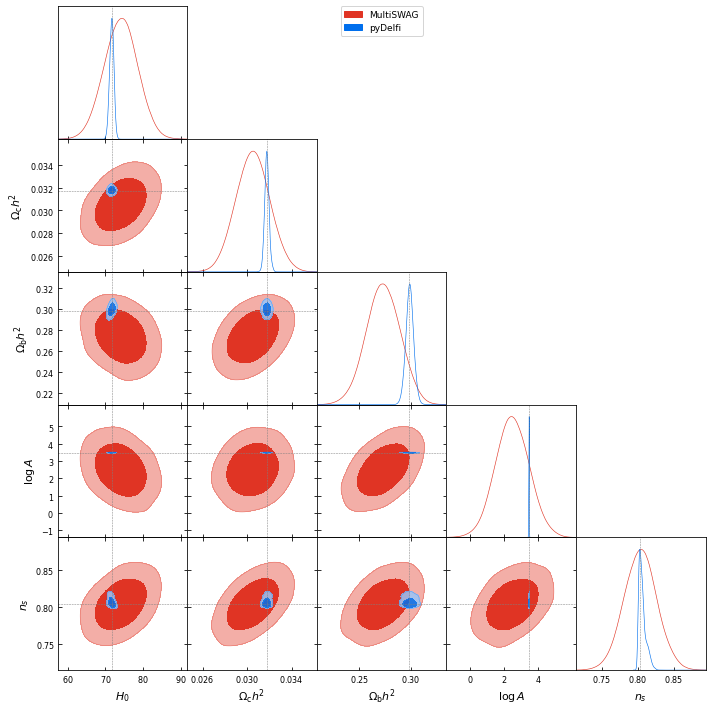

In [35]:
g = getdist.plots.getSubplotPlotter()
g.triangle_plot([swag, pydelfi], 
                ["H0", "omch2",  "ombh2", "As", "ns"], 
                filled=True,
                legend_labels = ['MultiSWAG', 'pyDelfi'],
                markers={'H0':params[-1,0],
                         'omch2':params[-1,1],
                         'ombh2':params[-1,2],
                         'As':params[-1,3],
                         'ns':params[-1,4]}
               )